In [ ]:
%pip install pandas numpy tensorflow scikit-learn matplotlib

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt

df = pd.read_csv("./outputs/Mexico_wosis_merged.csv")

# convert date to datetime
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')

# select numerical features
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns

# normalize numerical features
df_scaled = df.copy()
scaler = MinMaxScaler()
df_scaled[numerical_features] = scaler.fit_transform(df_scaled[numerical_features])

df_scaled.head()

,date,longitude,latitude,upper_depth,lower_depth,country_name,region,continent,bdfiod_value,bdwsod_value,...,cfvo_value,clay_value,ecec_value,nitkjd_value,orgc_value,phaq_value,sand_value,silt_value,tceq_value,totc_value
0,1900-01-01,0.000398,0.983436,0.00,0.551724,Mexico,Central America,Northern America,NaN,NaN,...,NaN,0.545455,NaN,NaN,NaN,0.666667,0.346939,0.183908,NaN,NaN
1931,1900-01-01,0.562923,0.512214,0.00,0.620690,Mexico,Central America,Northern America,NaN,NaN,...,NaN,0.500000,NaN,NaN,NaN,0.602564,0.204082,0.390805,NaN,NaN
1932,1900-01-01,0.563251,0.654240,0.00,0.448276,Mexico,Central America,Northern America,NaN,NaN,...,NaN,0.340909,NaN,NaN,NaN,0.589744,0.265306,0.482759,NaN,NaN
1933,1900-01-01,0.563251,0.654240,0.56,0.862069,Mexico,Central America,Northern America,NaN,NaN,...,NaN,0.340909,NaN,NaN,NaN,0.628205,0.244898,0.505747,NaN,NaN
1934,1900-01-01,0.563305,0.271189,0.00,0.689655,Mexico,Central America,Northern America,NaN,NaN,...,NaN,0.204545,NaN,NaN,NaN,0.410256,0.387755,0.482759,NaN,NaN


<Axes: >

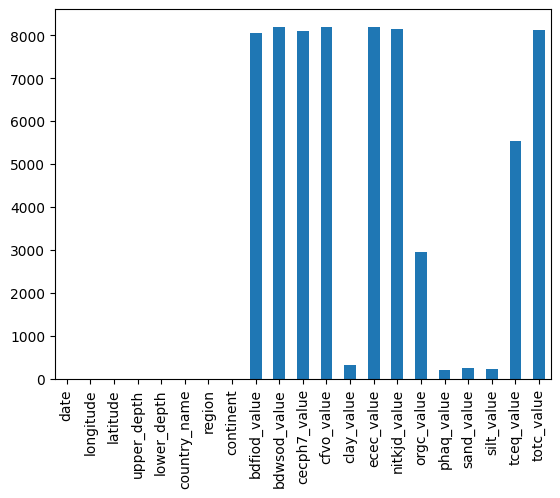

In [12]:
# plot missing values
df_scaled.isna().sum().plot(kind='bar')

In [19]:
# define temporal and static features
temporal_features = ["clay_value", "orgc_value", "phaq_value"]
static_features = ["latitude", "longitude", "upper_depth", "lower_depth"]


# Sequence creation function
def create_sequences(data, temporal_features, static_features, n_steps):
    X_seq, X_static, y = [], [], []
    grouped = data.groupby(["latitude", "longitude"])
    for _, group in grouped:
        for i in range(len(group) - n_steps):
            seq = group.iloc[i:i + n_steps][temporal_features].values
            static = group.iloc[0][static_features].values  # Static features are constant for a location
            target = group.iloc[i + n_steps]["orgc_value"]  # Target: Next pH value
            X_seq.append(seq)
            X_static.append(static)
            y.append(target)
    return np.array(X_seq), np.array(X_static), np.array(y)


# Generate sequences
n_steps = 3
X_seq, X_static, y = create_sequences(df, temporal_features, static_features, n_steps)

# Split data into train/test
X_seq_train, X_seq_test, X_static_train, X_static_test, y_train, y_test = train_test_split(
    X_seq, X_static, y, test_size=0.2, random_state=42
)

# Temporal input
seq_input = tf.keras.layers.Input(shape=(n_steps, len(temporal_features)), name="Temporal_Input")
x = tf.keras.layers.LSTM(64, activation="tanh", return_sequences=True)(seq_input)
x = tf.keras.layers.LSTM(32, activation="tanh")(x)

# Static input
static_input = tf.keras.layers.Input(shape=(len(static_features),), name="Static_Input")
y = tf.keras.layers.Dense(32, activation="relu")(static_input)

# Combine temporal and static inputs
combined = tf.keras.layers.Concatenate()([x, y])
z = tf.keras.layers.Dense(32, activation="relu")(combined)
z = tf.keras.layers.Dropout(0.2)(z)
output = tf.keras.layers.Dense(1, activation="linear", name="Output")(z)

# Define and compile model
model = tf.keras.Model(inputs=[seq_input, static_input], outputs=output)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Temporal_Input      │ (None, 3, 3)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ (None, 3, 64)     │     17,408 │ Temporal_Input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Static_Input        │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ (None, 32)        │     12,416 │ lstm_10[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 32)        │        160 │ Static_Input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 64)        │          0 │ lstm_11[0][0],    │
│ (Concatenate)       │                   │            │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 32)        │      2,080 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 32)        │          0 │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output (Dense)      │ (None, 1)         │         33 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 32,097 (125.38 KB)

 Trainable params: 32,097 (125.38 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: nan - mae: nan
Test Loss: nan, Test MAE: nan
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


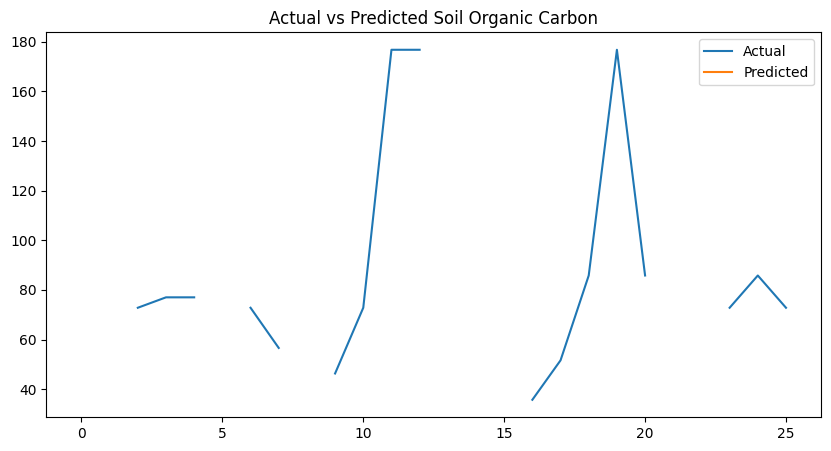

In [21]:
# convert to float32
X_seq_train = tf.convert_to_tensor(X_seq_train, dtype=tf.float32)
X_static_train = tf.convert_to_tensor(X_static_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_seq_test = tf.convert_to_tensor(X_seq_test, dtype=tf.float32)
X_static_test = tf.convert_to_tensor(X_static_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

# Train model
history = model.fit(
    [X_seq_train, X_static_train],
    y_train,
    validation_split=0.3,
    epochs=10,
    batch_size=16,
    verbose=0
)

# Evaluate model
loss, mae = model.evaluate([X_seq_test, X_static_test], y_test, verbose=1)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Visualise predictions
y_pred = model.predict([X_seq_test, X_static_test])

plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Soil Organic Carbon")
plt.show()